In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords_dict = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
path = 'drive/MyDrive/dataset/multilabel_comment_dataset.csv'

dataset = pd.read_csv(path, encoding = 'utf8')

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


In [ ]:
def remove_stopwords(text):
  words = [word for word in text.split() if word not in stopwords_dict]
  return " ".join(words)

dataset['comment_text'] = dataset['comment_text'].apply(remove_stopwords)

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists notice name change captio...,0,0,0,0,0,0,1
1,ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur immature frnziim ur evn debatingur year old...,1,0,1,0,1,1,0
3,hi goodday noted qwyrxian weighed issue learne...,0,0,0,0,0,0,1
4,fucks sake fucking stop spastic fucking moron ...,1,1,1,0,1,0,0


In [ ]:
raw_train, raw_validation, raw_test = np.split(dataset.sample(frac=1), [int(0.7*len(dataset)), int(0.9*len(dataset))])

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

def df_to_dataset(dataframe, shuffle=True, batch_size=2048):
  df = dataframe.copy()
  labels = df[['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']].values
  df = df['comment_text']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

raw_train_ds = df_to_dataset(raw_train)
raw_val_ds = df_to_dataset(raw_validation)
raw_test_ds = df_to_dataset(raw_test)

200652 training examples
57329 validation examples
28665 test examples


# Text Vectorization

The first layer of the model is **Text Vectorization** which converts the human string to number array. This is an preprocessing approach because neural network or even computer is not friendly with text but numeric data. There are some parameters that need to notice: **max_features** is vocabulary size of dataset (is restricted to 180,000), **sequence_length** defines the length of output (it will truncate the output to that length), the **output_mode='int'** cast the output array to an integer arr. Before using the layer, we adapt it with the train text so that the layer learns the vocabulary and dataset.

As the next step, we're passing all 3 datasets to the layer. The **vectorize_text** function will take 2 strings text and label, expanding the dimension of text tensor to match the expected input. In the last part, **cache(**) caches the dataset in memory to avoid bottlenecks and **prefetch** prefetches data for optimal performance, allowing for the autonamtic tuning of the buffer size.

In [ ]:
max_features = 180000
sequence_length = 300

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_sequence_length=sequence_length,
    output_mode='int'
)

train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model

In [ ]:
# embedding_dim = 32

# def create_cnn_model():
#     input = layers.Input(shape=(sequence_length,), dtype='int32')

#     tweet_encoder = layers.Embedding(max_features, embedding_dim, input_length=sequence_length)(input)
#     tweet_encoder = layers.Dropout(0.5)(tweet_encoder)

#     bigram_branch = layers.Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
#     bigram_branch = layers.GlobalMaxPooling1D()(bigram_branch)
#     bigram_branch = layers.Dropout(0.5)(bigram_branch)

#     trigram_branch = layers.Conv1D(filters=128, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
#     trigram_branch = layers.GlobalMaxPooling1D()(trigram_branch)
#     trigram_branch = layers.Dropout(0.2)(trigram_branch)

#     fourgram_branch = layers.Conv1D(filters=256, kernel_size=5, padding='valid', activation='relu', strides=1)(tweet_encoder)
#     fourgram_branch = layers.GlobalMaxPooling1D()(fourgram_branch)
#     fourgram_branch = layers.Dropout(0.2)(fourgram_branch)

#     merged = layers.concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=-1)

#     merged = layers.Dense(128, activation='relu')(merged)
#     merged = layers.Dropout(0.5)(merged)

#     merged = layers.Dense(7)(merged)
#     output = layers.Activation('sigmoid')(merged)



#     model = tf.keras.Model(inputs=[input], outputs=[output])
#     model.compile(loss=losses.BinaryCrossentropy(),
#                   optimizer='adam',
#                   metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

#     model.summary()

#     return model

# model = create_cnn_model()


In [ ]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Input(shape=(sequence_length,)),
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),

  layers.Conv1D(filters=16, kernel_size=3, padding='valid', activation='relu', strides=1),
  layers.MaxPooling1D(pool_size=2),
  layers.Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', strides=1),
  layers.MaxPooling1D(pool_size=2),
  layers.Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1),
  layers.MaxPooling1D(pool_size=2),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 32)           5760000   
                                                                 
 dropout_10 (Dropout)        (None, 300, 32)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 298, 16)           1552      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 149, 16)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 147, 32)           1568      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 73, 32)           0         
 1D)                                                  

In [ ]:
epochs = 6
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/8
98/98 [==============================] - 162s 2s/step - loss: 0.4737 - binary_accuracy: 0.7643 - val_loss: 0.2956 - val_binary_accuracy: 0.8653
Epoch 2/8
98/98 [==============================] - 158s 2s/step - loss: 0.2386 - binary_accuracy: 0.8921 - val_loss: 0.2078 - val_binary_accuracy: 0.9059
Epoch 3/8
98/98 [==============================] - 161s 2s/step - loss: 0.1804 - binary_accuracy: 0.9187 - val_loss: 0.1763 - val_binary_accuracy: 0.9209
Epoch 4/8
98/98 [==============================] - 160s 2s/step - loss: 0.1496 - binary_accuracy: 0.9347 - val_loss: 0.1507 - val_binary_accuracy: 0.9364
Epoch 5/8
98/98 [==============================] - 161s 2s/step - loss: 0.1225 - binary_accuracy: 0.9479 - val_loss: 0.1280 - val_binary_accuracy: 0.9484
Epoch 6/8
98/98 [==============================] - 158s 2s/step - loss: 0.1014 - binary_accuracy: 0.9583 - val_loss: 0.1111 - val_binary_accuracy: 0.9579
Epoch 7/8
98/98 [==============================] - 159s 2s/step - loss: 0.08

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

14/14 [==============================] - 3s 235ms/step - loss: 0.0658 - binary_accuracy: 0.9812
Loss:  0.065804123878479
Accuracy:  0.9812414646148682


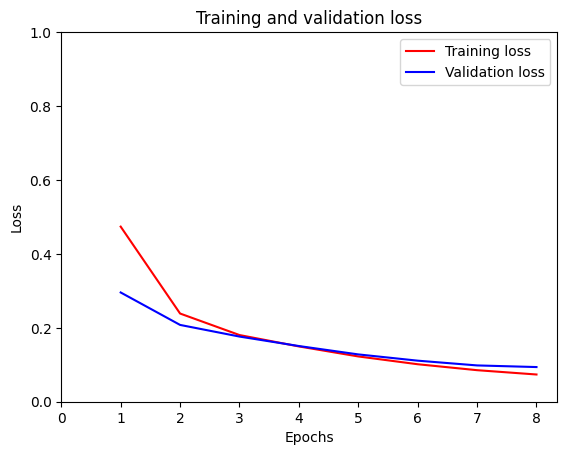

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

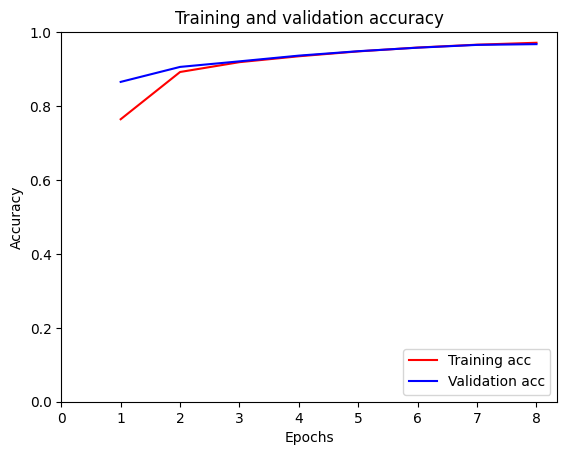

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
])

export_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,


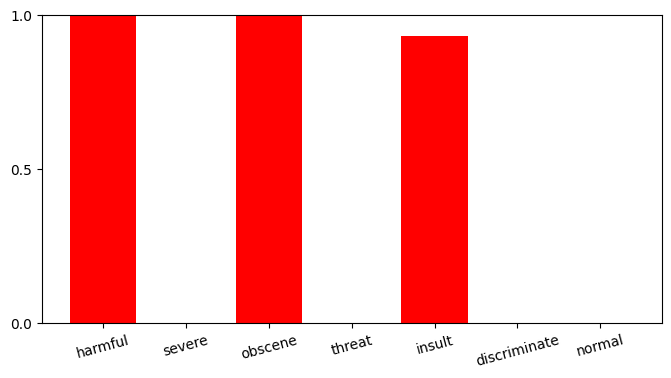

Dear god this site is horrible.


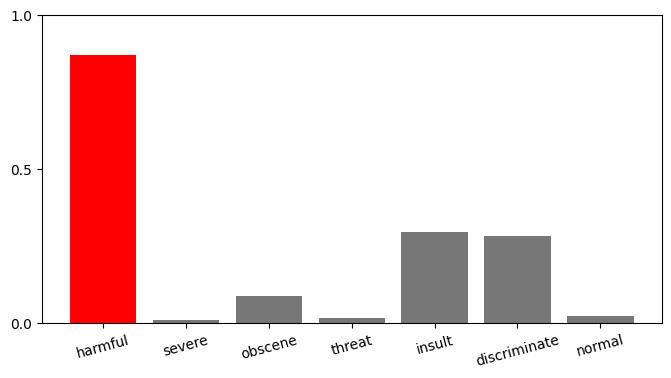

Only a fool can believe in such numbers.


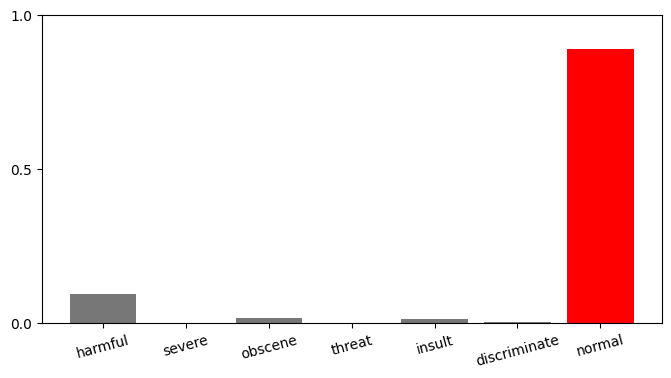

I have indefinitely blocked this account.


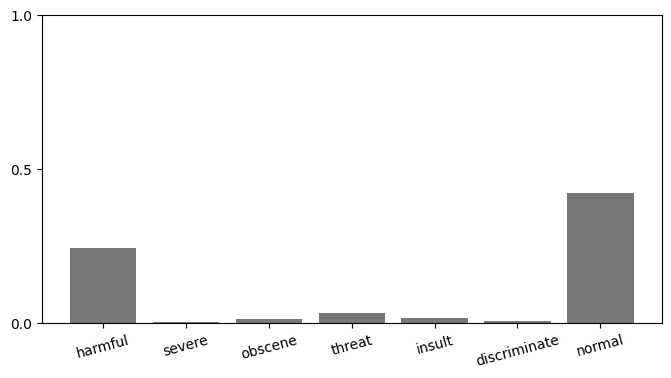

Love the commitment bitch


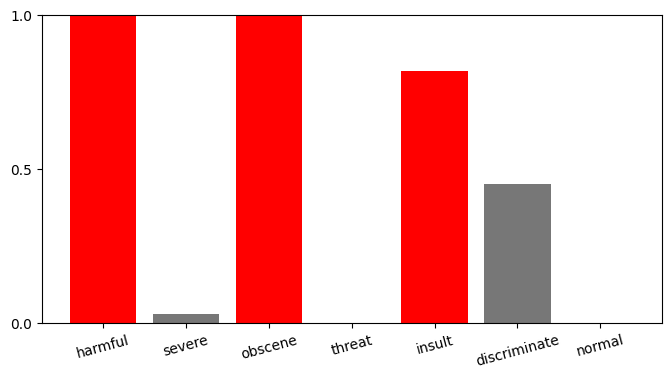

hello how are you


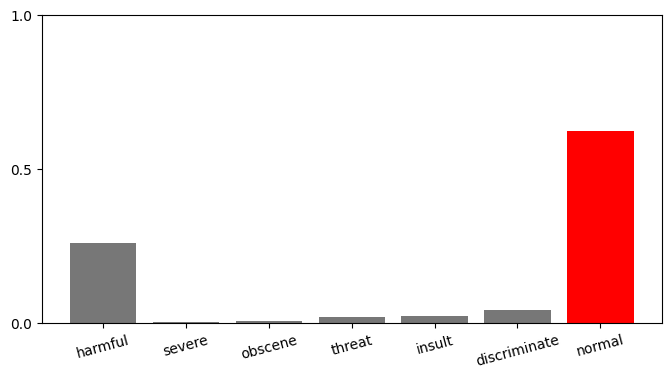

In [ ]:
inputs = [
  "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Love the commitment bitch",
  "hello how are you"
]

examples = tf.constant(inputs)
def plot_value_array(prediction):
  colors=["red" if pred >= 0.5 else "#777777" for pred in prediction]
  thisplot = plt.bar(range(len(prediction)), prediction, color=colors)
  plt.xticks(range(len(prediction)), ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal'], rotation=15)
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])

predictions = export_model.predict(examples)

for i in range(len(inputs)):
  plt.figure(figsize=(8, 4))
  print(inputs[i])
  plot_value_array(predictions[i])
  plt.show()